# Optimization Problems

Wikipedia: https://en.wikipedia.org/wiki/Optimization_problem

Given a target (loss) function and a set of parameters. Find the parameters set (subjects to constraints) to minimize the function.

- Curve fitting: [LsqFit.jl](https://github.com/JuliaNLSolvers/LsqFit.jl)
- General optimization problems: [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl)
- Use with ModelingToolkit: [Optimization.jl](https://github.com/SciML/Optimization.jl)

## Curve fitting using LsqFit

[LsqFit.jl](https://github.com/JuliaNLSolvers/LsqFit.jl) package is a small library that provides basic least-squares fitting in pure Julia.

In [1]:
using LsqFit
@. model(x, p) = p[1] * exp(-x * p[2])

model (generic function with 1 method)

Generate data

In [2]:
xdata = range(0, stop=10, length=20)
ydata = model(xdata, [1.0 2.0]) + 0.01 * randn(length(xdata))

20-element Vector{Float64}:
  0.9951900141360756
  0.33519718802223236
  0.12075481994948987
  0.030653612252467023
  0.011419394405670828
  0.010048834244321639
  0.0029466734064834323
 -0.008785573929764284
  0.0039713341337260745
  0.0003947201221665279
 -0.004788066086078154
 -0.010718947896685968
 -0.009167646545741877
  0.017105102252478604
 -0.02136137726284783
 -0.0006076627485449745
 -0.0029574026006394484
  0.0023789428916753427
 -0.005796147231326685
  0.012836781664337053

Initial guess

In [3]:
p0 = [0.5, 0.5]

2-element Vector{Float64}:
 0.5
 0.5

Fit the model

In [4]:
fit = curve_fit(model, xdata, ydata, p0; autodiff=:forwarddiff)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.9950321626358397, 2.0571600981877873], [-0.00015785150023583938, 0.0017948215967484304, -0.006624223159322526, 0.007999509340556321, 0.0016714318136288944, -0.0056153053586536755, -0.0014451502748820647, 0.009294101509684247, -0.0037991088152499893, -0.00033639180036959147, 0.004807820400680391, 0.010725638179097361, 0.00916991237372151, -0.01710433487434453, 0.021361637154245567, 0.0006077507671314025, 0.0029574324102892647, -0.002378932795907412, 0.005796150650505734, -0.012836780506348334], [1.0 0.0; 0.33867448940171857 -0.17736421558893728; … ; 3.436249779127088e-9 -3.2392222570248184e-8; 1.1637701394026368e-9 -1.1579887186208183e-8], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

The parameters

In [5]:
coef(fit)

2-element Vector{Float64}:
 0.9950321626358397
 2.0571600981877873

## Curve fitting using Optimization.jl

In [6]:
using Optimization
using OptimizationOptimJL

@. model(x, p) = p[1] * exp(-x * p[2])

model (generic function with 1 method)

Generate data

In [7]:
xdata = range(0, stop=10, length=20)
ydata = model(xdata, [1.0 2.0]) + 0.01 * randn(length(xdata))

function lossl2(p, data)
    x, y = data
    y_pred = model(x, p)
    return sum(abs2, y_pred .- y)
end

p0 = [0.5, 0.5]
data = [xdata, ydata]
prob = OptimizationProblem(lossl2, p0, data)
res = solve(prob, Optim.NelderMead())

retcode: Success
u: 2-element Vector{Float64}:
 1.0037129507961933
 1.9916205700144363

## 2D Rosenbrock Function

From: https://docs.sciml.ai/ModelingToolkit/stable/tutorials/optimization/
Wikipedia: https://en.wikipedia.org/wiki/Rosenbrock_function

Find $(x, y)$ that minimizes the loss function $(a - x)^2 + b(y - x^2)^2$

In [8]:
using ModelingToolkit
using Optimization
using OptimizationOptimJL

In [9]:
@variables begin
    x, [bounds = (-2.0, 2.0)]
    y, [bounds = (-1.0, 3.0)]
end

@parameters a b

2-element Vector{Symbolics.Num}:
 a
 b

Define the target (loss) function
The optimization algorithm will try to minimize its value

In [10]:
loss = (a - x)^2 + b * (y - x^2)^2

(a - x)^2 + b*((y - (x^2))^2)

Build the OptimizationSystem

In [11]:
@mtkbuild sys = OptimizationSystem(loss, [x, y], [a, b])

Model sys:
Unknowns (2): see unknowns(sys)
  x
  y
Parameters (2): see parameters(sys)
  a
  b

Initial guess

In [12]:
u0 = [x => 1.0, y => 2.0]

2-element Vector{Pair{Symbolics.Num, Float64}}:
 x => 1.0
 y => 2.0

parameters

In [13]:
p = [a => 1.0, b => 100.0]

2-element Vector{Pair{Symbolics.Num, Float64}}:
 a => 1.0
 b => 100.0

ModelingToolkit can generate gradient and Hessian to solve the problem more efficiently.

In [14]:
prob = OptimizationProblem(sys, u0, p, grad=true, hess=true)

OptimizationProblem. In-place: true
u0: 2-element Vector{Float64}:
 1.0
 2.0

Solve the problem
The true solution is (1.0, 1.0)

In [15]:
u_opt = solve(prob, GradientDescent())

retcode: Success
u: 2-element Vector{Float64}:
 1.0000000138998895
 1.0000000278443366

### Adding constraints
`OptimizationSystem(..., constraints = cons)`

In [16]:
@variables begin
    x, [bounds = (-2.0, 2.0)]
    y, [bounds = (-1.0, 3.0)]
end

@parameters a = 1 b = 100

loss = (a - x)^2 + b * (y - x^2)^2

(a - x)^2 + b*((y - (x^2))^2)

Constraints are define using `≲` (`\lesssim`) or `≳` (`\gtrsim`)

In [17]:
cons = [
    x^2 + y^2 ≲ 1,
]
@mtkbuild sys = OptimizationSystem(loss, [x, y], [a, b], constraints=cons)

Model sys:
Unknowns (2): see unknowns(sys)
  x
  y
Parameters (2): see parameters(sys)
  a [defaults to 1]
  b [defaults to 100]

In [18]:
u0 = [x => 0.14, y => 0.14]
prob = OptimizationProblem(sys, u0, grad=true, hess=true, cons_j=true, cons_h=true)

OptimizationProblem. In-place: true
u0: 2-element Vector{Float64}:
 0.14
 0.14

Use interior point Newton method for constrained optimization

In [19]:
solve(prob, IPNewton())

┌ Warning: The selected optimization algorithm requires second order derivatives, but `SecondOrder` ADtype was not provided. 
│         So a `SecondOrder` with SciMLBase.NoAD() for both inner and outer will be created, this can be suboptimal and not work in some cases so 
│         an explicit `SecondOrder` ADtype is recommended.
└ @ OptimizationBase ~/.julia/packages/OptimizationBase/1tTb9/src/cache.jl:49


retcode: Success
u: 2-element Vector{Float64}:
 0.7864151541684254
 0.6176983125233897

## Parameter estimation

From: https://docs.sciml.ai/DiffEqParamEstim/stable/getting_started/

`DiffEqParamEstim.jl` is not installed with `DifferentialEquations.jl`. You need to install it manually:

```julia
using Pkg
Pkg.add("DiffEqParamEstim")
using DiffEqParamEstim
```

The key function is `DiffEqParamEstim.build_loss_objective()`, which builds a loss (objective) function for the problem against the data. Then we can use optimization packages to solve the problem.

### Estimate a single parameter from the data and the ODE model

Let's optimize the parameters of the Lotka-Volterra equation.

In [20]:
using OrdinaryDiffEq
using Plots
using DiffEqParamEstim
using ForwardDiff
using Optimization
using OptimizationOptimJL

Example model

In [21]:
function lotka_volterra!(du, u, p, t)
    du[1] = dx = p[1] * u[1] - u[1] * u[2]
    du[2] = dy = -3 * u[2] + u[1] * u[2]
end

u0 = [1.0; 1.0]
tspan = (0.0, 10.0)
p = [1.5] ## The true parameter value
prob = ODEProblem(lotka_volterra!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 1.0

True solution

In [22]:
sol = solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 34-element Vector{Float64}:
  0.0
  0.0776084743154256
  0.2326451370670694
  0.42911851563726466
  0.679082199936808
  0.9444046279774128
  1.2674601918628516
  1.61929140093895
  1.9869755481702074
  2.2640903679981617
  ⋮
  7.5848624442719235
  7.978067891667038
  8.483164641366145
  8.719247691882519
  8.949206449510513
  9.200184762926114
  9.438028551201125
  9.711807820573478
 10.0
u: 34-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0454942346944578, 0.8576684823217128]
 [1.1758715885890039, 0.6394595702308831]
 [1.419680958026516, 0.45699626144050703]
 [1.8767193976262215, 0.3247334288460738]
 [2.5882501035146133, 0.26336255403957304]
 [3.860709084797009, 0.27944581878759106]
 [5.750813064347339, 0.5220073551361045]
 [6.814978696356636, 1.917783405671627]
 [4.392997771045279, 4.194671543390719]
 ⋮
 [2.6142510825026886, 0.2641695435004172]
 [4.241070648057757, 0.30512326533052475]
 [6.79112182569163

Create a sample dataset with some noise.

In [23]:
ts = range(tspan[begin], tspan[end], 200)
data = [sol.(ts, idxs=1) sol.(ts, idxs=2)] .* (1 .+ 0.03 .* randn(length(ts), 2))

200×2 Matrix{Float64}:
 1.00176   0.983414
 1.03513   0.905472
 1.0647    0.839663
 1.08303   0.757708
 1.10993   0.660478
 1.13858   0.586043
 1.22668   0.535837
 1.37551   0.508724
 1.35695   0.493475
 1.4746    0.465015
 ⋮         
 0.995737  2.17554
 0.942074  1.88702
 0.996527  1.71259
 0.991312  1.45228
 0.950633  1.37916
 0.97781   1.21545
 0.99857   1.09141
 1.0446    0.988052
 1.00411   0.878124

Plotting the sample dataset and the true solution.

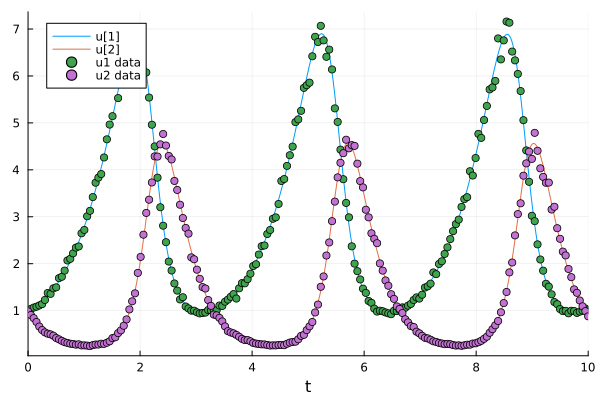

In [24]:
plot(sol)
scatter!(ts, data, label=["u1 data" "u2 data"])

`DiffEqParamEstim.build_loss_objective()` builds a loss function for the ODE problem for the data.

We will minimize the mean squared error using `L2Loss()`.

Note that
- the data should be transposed.
- Uses `AutoForwardDiff()` as the automatic differentiation (AD) method since the number of parameters plus states is small (<100). For larger problems, `Optimization.AutoZygote()` is more efficient.

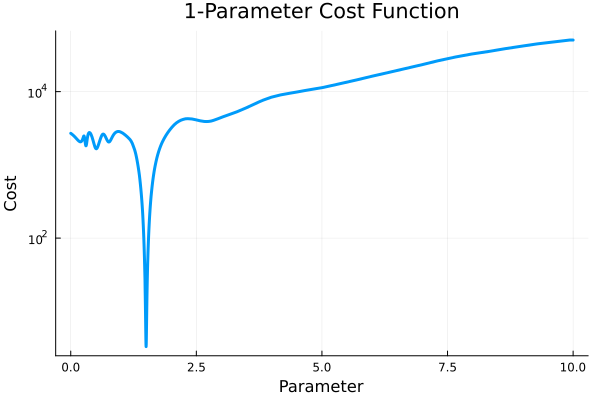

In [25]:
alg = Tsit5()

cost_function = build_loss_objective(
    prob, alg,
    L2Loss(collect(ts), transpose(data)),
    Optimization.AutoForwardDiff(),
    maxiters=10000, verbose=false
)

plot(
    cost_function, 0.0, 10.0,
    linewidth=3, label=false, yscale=:log10,
    xaxis="Parameter", yaxis="Cost", title="1-Parameter Cost Function"
)

There is a dip (minimum) in the cost function at the true parameter value (1.5). We can use an optimizer e.g., `Optimization.jl`, to find the parameter value that minimizes the cost. (1.5 in this case)

In [26]:
optprob = Optimization.OptimizationProblem(cost_function, [1.42])
optsol = solve(optprob, BFGS())

retcode: Success
u: 1-element Vector{Float64}:
 1.500490863813885

The fitting result:

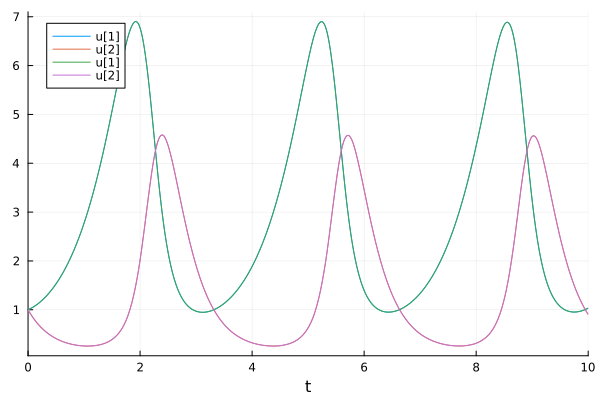

In [27]:
newprob = remake(prob, p=optsol.u)
newsol = solve(newprob, Tsit5())
plot(sol)
plot!(newsol)

### Estimate multiple parameters
Let's use the Lotka-Volterra (Fox-rabbit) equations with all 4 parameters free.

In [28]:
function f2(du, u, p, t)
    du[1] = dx = p[1] * u[1] - p[2] * u[1] * u[2]
    du[2] = dy = -p[3] * u[2] + p[4] * u[1] * u[2]
end

u0 = [1.0; 1.0]
tspan = (0.0, 10.0)
p = [1.5, 1.0, 3.0, 1.0]  ## True parameters
alg = Tsit5()
prob = ODEProblem(f2, u0, tspan, p)
sol = solve(prob, alg)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 34-element Vector{Float64}:
  0.0
  0.0776084743154256
  0.2326451370670694
  0.42911851563726466
  0.679082199936808
  0.9444046279774128
  1.2674601918628516
  1.61929140093895
  1.9869755481702074
  2.2640903679981617
  ⋮
  7.5848624442719235
  7.978067891667038
  8.483164641366145
  8.719247691882519
  8.949206449510513
  9.200184762926114
  9.438028551201125
  9.711807820573478
 10.0
u: 34-element Vector{Vector{Float64}}:
 [1.0, 1.0]
 [1.0454942346944578, 0.8576684823217128]
 [1.1758715885890039, 0.6394595702308831]
 [1.419680958026516, 0.45699626144050703]
 [1.8767193976262215, 0.3247334288460738]
 [2.5882501035146133, 0.26336255403957304]
 [3.860709084797009, 0.27944581878759106]
 [5.750813064347339, 0.5220073551361045]
 [6.814978696356636, 1.917783405671627]
 [4.392997771045279, 4.194671543390719]
 ⋮
 [2.6142510825026886, 0.2641695435004172]
 [4.241070648057757, 0.30512326533052475]
 [6.79112182569163

In [29]:
ts = range(tspan[begin], tspan[end], 200)
data = [sol.(ts, idxs=1) sol.(ts, idxs=2)] .* (1 .+ 0.01 .* randn(length(ts), 2))

200×2 Matrix{Float64}:
 0.98799   0.994206
 1.02654   0.905838
 1.04174   0.827122
 1.11539   0.736517
 1.13373   0.684612
 1.18001   0.613938
 1.24875   0.567966
 1.30431   0.524469
 1.39943   0.48036
 1.43474   0.444039
 ⋮         
 1.00075   2.07236
 0.981757  1.86871
 0.949468  1.6642
 0.975272  1.5043
 0.953091  1.39571
 0.964585  1.24121
 0.98573   1.10326
 0.98464   1.00433
 1.02059   0.912735

Then we can find multiple parameters at once using the same steps. True parameters are `[1.5, 1.0, 3.0, 1.0]`.

In [30]:
cost_function = build_loss_objective(
    prob, alg, L2Loss(collect(ts), transpose(data)),
    Optimization.AutoForwardDiff(),
    maxiters=10000, verbose=false
)
optprob = Optimization.OptimizationProblem(cost_function, [1.3, 0.8, 2.8, 1.2])
result_bfgs = solve(optprob, LBFGS())

retcode: Success
u: 4-element Vector{Float64}:
 1.4991283356630827
 0.9995618707169693
 3.0024105967502708
 1.0019867755492156

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*